## LangChain: Memory

When you interact with these models, they don't remember what you say before or any of the previous conversation, which is an issue when you are building some applications like chatbot and you want to have conversation with them. In this section we'll cover memory, which is basically how do you remember previous parts of the conversation and feed that into the language model so that they can have this conversational flow as you're interacting with them.

LangChain offers multiple sophisticated options of managing these memories. Let's jump in and take a look.

### Outline
- `ConversationBufferMemory`
- `ConversationBufferWindowMemory`
- `ConversationTokenBuffermemory`
- `ConversationSummaryMemory`

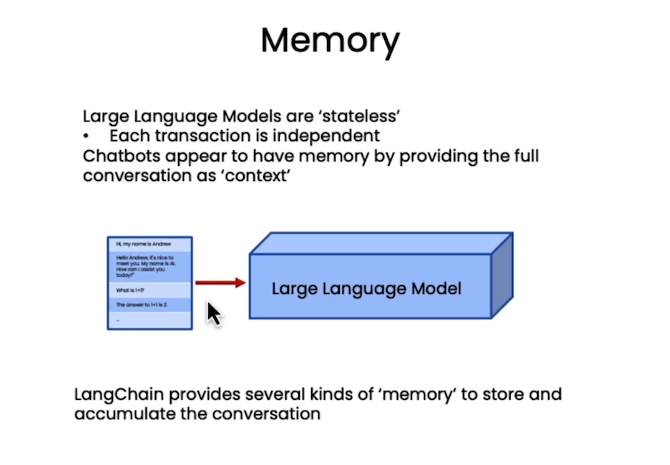
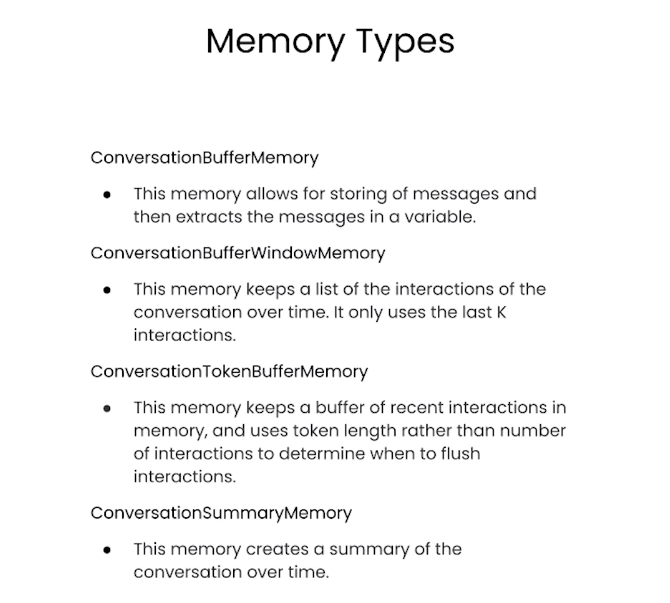

In [1]:
import openai
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

OPENAI_KEY = os.getenv('OPENAI_KEY')
openai.api_key = OPENAI_KEY

def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

#### ConversationBufferMemory
The ConversationBufferMemory is the most straightforward conversational memory in LangChain. As we described above, the raw input of the past conversation between the human and AI is passed — in its raw form — to the {history} parameter.

NOTE: you can use something like the code shown below to keep track of tokens used
```python
from langchain.callbacks import get_openai_callback

def count_tokens(chain, query):
    with get_openai_callback() as cb:
        result = chain.run(query)
        print(f'Spent a total of {cb.total_tokens} tokens')

    return result

count_tokens(
    conversation_buf, 
    "My interest here is to explore the potential of integrating Large Language Models with external knowledge"
)

## OUTPUT
Spent a total of 179 tokens

' Interesting! Large Language Models are a type of artificial intelligence that can process natural language and generate text. They can be used to generate text from a given context, or to answer questions about a given context. Integrating them with external knowledge can help them to better understand the context and generate more accurate results. Is there anything else I can help you with?'
```

In [12]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

chat = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo", openai_api_key=OPENAI_KEY)

memory = ConversationBufferMemory()
conversation = ConversationChain(
    llm=chat, memory=memory, verbose=True # verbose: True will show what the langchain is doing
)

In [13]:
conversation.predict(input="Hi, My name is Mrinal Sinha")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, My name is Mrinal Sinha
AI:

> Finished chain.


'Hello Mrinal Sinha! How can I assist you today?'

In [14]:
conversation.predict(input="What is 1+1")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, My name is Mrinal Sinha
AI: Hello Mrinal Sinha! How can I assist you today?
Human: What is 1+1
AI:

> Finished chain.


'1+1 is equal to 2.'

In [15]:
conversation.predict(input="What is my name?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, My name is Mrinal Sinha
AI: Hello Mrinal Sinha! How can I assist you today?
Human: What is 1+1
AI: 1+1 is equal to 2.
Human: What is my name?
AI:

> Finished chain.


'Your name is Mrinal Sinha.'

In [16]:
memory.buffer

'Human: Hi, My name is Mrinal Sinha\nAI: Hello Mrinal Sinha! How can I assist you today?\nHuman: What is 1+1\nAI: 1+1 is equal to 2.\nHuman: What is my name?\nAI: Your name is Mrinal Sinha.'

In [17]:
memory.load_memory_variables({})

{'history': 'Human: Hi, My name is Mrinal Sinha\nAI: Hello Mrinal Sinha! How can I assist you today?\nHuman: What is 1+1\nAI: 1+1 is equal to 2.\nHuman: What is my name?\nAI: Your name is Mrinal Sinha.'}

In [19]:
# You can save custom context in the memory
memory = ConversationBufferMemory()
memory.save_context({"input": "Hi"}, 
                    {"output": "What's up"})
print(memory.buffer)
print(memory.load_memory_variables({}))

Human: Hi
AI: What's up
{'history': "Human: Hi\nAI: What's up"}


#### ConversationBufferWindowMemory
The ConversationBufferWindowMemory acts in the same way as our earlier “buffer memory” but adds a window to the memory. Meaning that we only keep a given number of past interactions before “forgetting” them. 

In [20]:
from langchain.memory import ConversationBufferWindowMemory

# In this instance, we set k=1 — this means the window will remember the single latest interaction between the human and AI. 
#That is the latest human response and the latest AI response. 
memory = ConversationBufferWindowMemory(k=1)

memory.save_context({"input": "Hi"},
                    {"output": "What's up"})
memory.save_context({"input": "Not much, just hanging"},
                    {"output": "Cool"})

memory.load_memory_variables({})

{'history': 'Human: Not much, just hanging\nAI: Cool'}

In [25]:
conversation = ConversationChain(llm=chat, memory=memory, verbose=False)

In [26]:
conversation.predict(input="Hi, my name is Mrinal Sinha")

'Hello Mrinal Sinha! How can I assist you today?'

In [27]:
conversation.predict(input='What is 1+1?')

'1+1 is equal to 2.'

In [28]:
conversation.predict(input='What is my name ?')

"I'm sorry, but I don't have access to personal information."

#### ConversationTokenBufferMemory
ConversationTokenBufferMemory keeps a buffer of recent interactions in memory, and uses token length rather than number of interactions to determine when to flush interactions.

In [29]:
from langchain.memory import ConversationTokenBufferMemory

memory = ConversationTokenBufferMemory(llm=chat, max_token_limit=50)
memory.save_context({"input": "AI is what?!"},
                    {"output": "Amazing!"})
memory.save_context({"input": "Backpropagation is what?"},
                    {"output": "Beautiful!"})
memory.save_context({"input": "Chatbots are what?"}, 
                    {"output": "Charming!"})
memory.load_memory_variables({})

{'history': 'AI: Amazing!\nHuman: Backpropagation is what?\nAI: Beautiful!\nHuman: Chatbots are what?\nAI: Charming!'}

#### ConversationSummaryMemory
This type of memory creates a summary of the conversation over time. This can be useful for condensing information from the conversation over time. Conversation summary memory summarizes the conversation as it happens and stores the current summary in memory. This memory can then be used to inject the summary of the conversation so far into a prompt/chain. This memory is most useful for longer conversations, where keeping the past message history in the prompt verbatim would take up too many tokens.

In [31]:
from langchain.memory import ConversationSummaryBufferMemory

# create a long string
schedule = "There is a meeting at 8am with your product team. \
You will need your powerpoint presentation prepared. \
9am-12pm have time to work on your LangChain \
project which will go quickly because Langchain is such a powerful tool. \
At Noon, lunch at the italian resturant with a customer who is driving \
from over an hour away to meet you to understand the latest in AI. \
Be sure to bring your laptop to show the latest LLM demo."

memory = ConversationSummaryBufferMemory(llm=chat, max_token_limit=100)
memory.save_context({"input": "Hello"}, {"output": "What's up"})
memory.save_context({"input": "Not much, just hanging"},
                    {"output": "Cool"})
memory.save_context({"input": "What is on the schedule today?"}, 
                    {"output": f"{schedule}"})

memory.load_memory_variables({})

{'history': 'System: The human and AI exchange greetings. The human asks about the schedule for the day. The AI provides a detailed schedule, including a meeting with the product team, work on the LangChain project, and a lunch meeting with a customer interested in AI. The AI emphasizes the importance of bringing a laptop to showcase the latest LLM demo during the lunch meeting.'}

In [32]:
conversation = ConversationChain(
    llm=chat, 
    memory = memory,
    verbose=True
)

In [33]:
conversation.predict(input='What would be a good demo to show ??')



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
System: The human and AI exchange greetings. The human asks about the schedule for the day. The AI provides a detailed schedule, including a meeting with the product team, work on the LangChain project, and a lunch meeting with a customer interested in AI. The AI emphasizes the importance of bringing a laptop to showcase the latest LLM demo during the lunch meeting.
Human: What would be a good demo to show ??
AI:

> Finished chain.


'A good demo to show during the lunch meeting with the customer interested in AI would be the latest LLM (Language Model) demo. The LLM is a cutting-edge language model developed by our team, and it has some impressive capabilities. It can generate human-like text, answer questions, and even engage in natural language conversations. By showcasing the LLM demo, you can demonstrate the power and potential of our AI technology to the customer. It would be great to highlight some specific use cases or scenarios where the LLM can be applied, such as content generation, customer support, or language translation. Additionally, you can also showcase any recent improvements or updates made to the LLM, such as enhanced accuracy, faster response times, or new features. Remember to bring your laptop to the lunch meeting so that you can give a live demonstration and allow the customer to interact with the LLM directly.'

In [34]:
memory.load_memory_variables({})

{'history': 'System: The human and AI exchange greetings and discuss the schedule for the day. The AI provides a detailed schedule, including a meeting with the product team, work on the LangChain project, and a lunch meeting with a customer interested in AI. The AI emphasizes the importance of bringing a laptop to showcase the latest LLM demo during the lunch meeting. The human asks what would be a good demo to show, and the AI suggests showcasing the latest LLM (Language Model) demo. The LLM is a cutting-edge language model developed by the team, capable of generating human-like text, answering questions, and engaging in natural language conversations. The AI advises highlighting specific use cases and scenarios where the LLM can be applied, such as content generation, customer support, or language translation. It also suggests showcasing any recent improvements or updates made to the LLM. The AI reminds the human to bring their laptop for a live demonstration and interaction with th

### Additional Memory Types
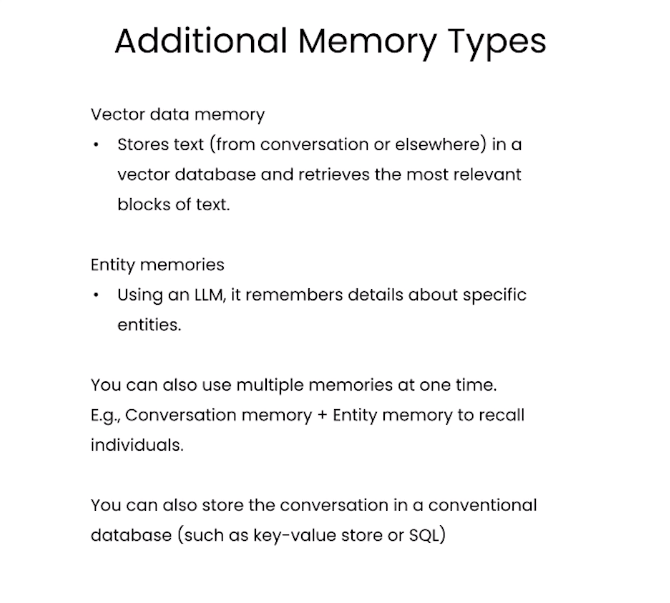